In [1]:
# install dependencies
# this cell might take some time to run, be patient
import sys

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install statsmodels

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Part A

import pandas as pd

airbnb_df = pd.read_csv('airbnb data.csv')
airbnb_df = airbnb_df.loc[:, ['accommodates', 'bathrooms','neighbourhood','num_beds','price','property_type']]

In [3]:
airbnb_df

,accommodates,bathrooms,neighbourhood,num_beds,price,property_type
0,1.0,1.0,Kitsilano,1,39,Apartment
1,1.0,1.0,Kensington-Cedar Cottage,1,43,Townhouse
2,2.0,1.0,Dunbar-Southlands,1,20,Apartment
3,3.0,1.0,Fraserview,1,49,Bed and breakfast
4,2.0,1.0,Oakridge,1,49,Villa
...,...,...,...,...,...,...
405,5.0,2.5,Kitsilano,5,249,House
406,4.0,1.0,Mount Pleasant,5,224,House
407,6.0,1.5,Riley Park,5,220,House
408,6.0,1.0,Downtown Vancouver,1,13,Condominium


In [4]:
# return the smoothed mean encoding
def get_smooth_mean_encode (df, cat_name, target, weight):
    mean = df[target].mean()
    agg = df.groupby(cat_name)[target].agg(["count", "mean"])
    counts = agg["count"]
    means = agg["mean"]
    smooth = (counts * means + weight * mean) / (counts + weight)
    return smooth

In [5]:
# Part B

airbnb_no_nan = airbnb_df.dropna()

airbnb_no_duplicates = airbnb_no_nan.drop_duplicates()

weight = 10
mean_encode_neighbourhood = get_smooth_mean_encode(airbnb_no_duplicates, "neighbourhood", "price", weight)
mean_encode_property_type = get_smooth_mean_encode(airbnb_no_duplicates, "property_type", "price", weight)

pd.set_option('mode.chained_assignment', None)

airbnb_no_duplicates.loc[: ,'neighbourhood_enc'] = airbnb_no_duplicates["neighbourhood"].map(mean_encode_neighbourhood)
airbnb_no_duplicates.loc[: ,'property_type_enc'] = airbnb_no_duplicates["property_type"].map(mean_encode_property_type)
airbnb_no_duplicates

,accommodates,bathrooms,neighbourhood,num_beds,price,property_type,neighbourhood_enc,property_type_enc
0,1.0,1.0,Kitsilano,1,39,Apartment,125.809959,69.143398
1,1.0,1.0,Kensington-Cedar Cottage,1,43,Townhouse,139.905285,106.935272
2,2.0,1.0,Dunbar-Southlands,1,20,Apartment,134.943902,69.143398
3,3.0,1.0,Fraserview,1,49,Bed and breakfast,153.119919,118.196231
4,2.0,1.0,Oakridge,1,49,Villa,131.082753,96.810569
...,...,...,...,...,...,...,...,...
403,4.0,1.0,Mount Pleasant,5,240,House,122.890244,190.939987
404,7.0,3.0,Grandview-Woodland,5,234,House,136.039950,190.939987
405,5.0,2.5,Kitsilano,5,249,House,125.809959,190.939987
406,4.0,1.0,Mount Pleasant,5,224,House,122.890244,190.939987


Regression model only takes in numerical value.
neighbourhood and property_type are categorical hence we need to have a way to encode them.
One hot encoding could be a possible solution but we opt that solution out as there is too many cardinality if we were to use this type of encoding.
Label encoding is not chosen as there is no relation between each category but this type of encoding might introduce unintended relation when used with certain algorithms.
In this project, we implemented mean encoding / target encoding. Much like label encoding, this encoding method brings out the relation between similar categories, but the relations are bounded within the categories and target itself. It does not increase the size of the data hence make it a good alternative for the one hot encoding.
One problem associated with mean encoding is overfitting of the model (eg. when there is only 1 value for a particulat category). Hence smoothing is done to overcome the problem. The weight of the smoothing is a hyperparameter hence it has to be tuned by trial and error to get the optimum result for the model.

In [6]:
# Part C

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

features = ["accommodates", "bathrooms", "num_beds","neighbourhood_enc", "property_type_enc"]
X = airbnb_no_duplicates.loc[:, features]
Y = airbnb_no_duplicates.loc[:, ["price"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
print ("Number of train data:", len(X_train))
print ("Number of test data:", len(X_test))

Number of train data: 229
Number of test data: 99


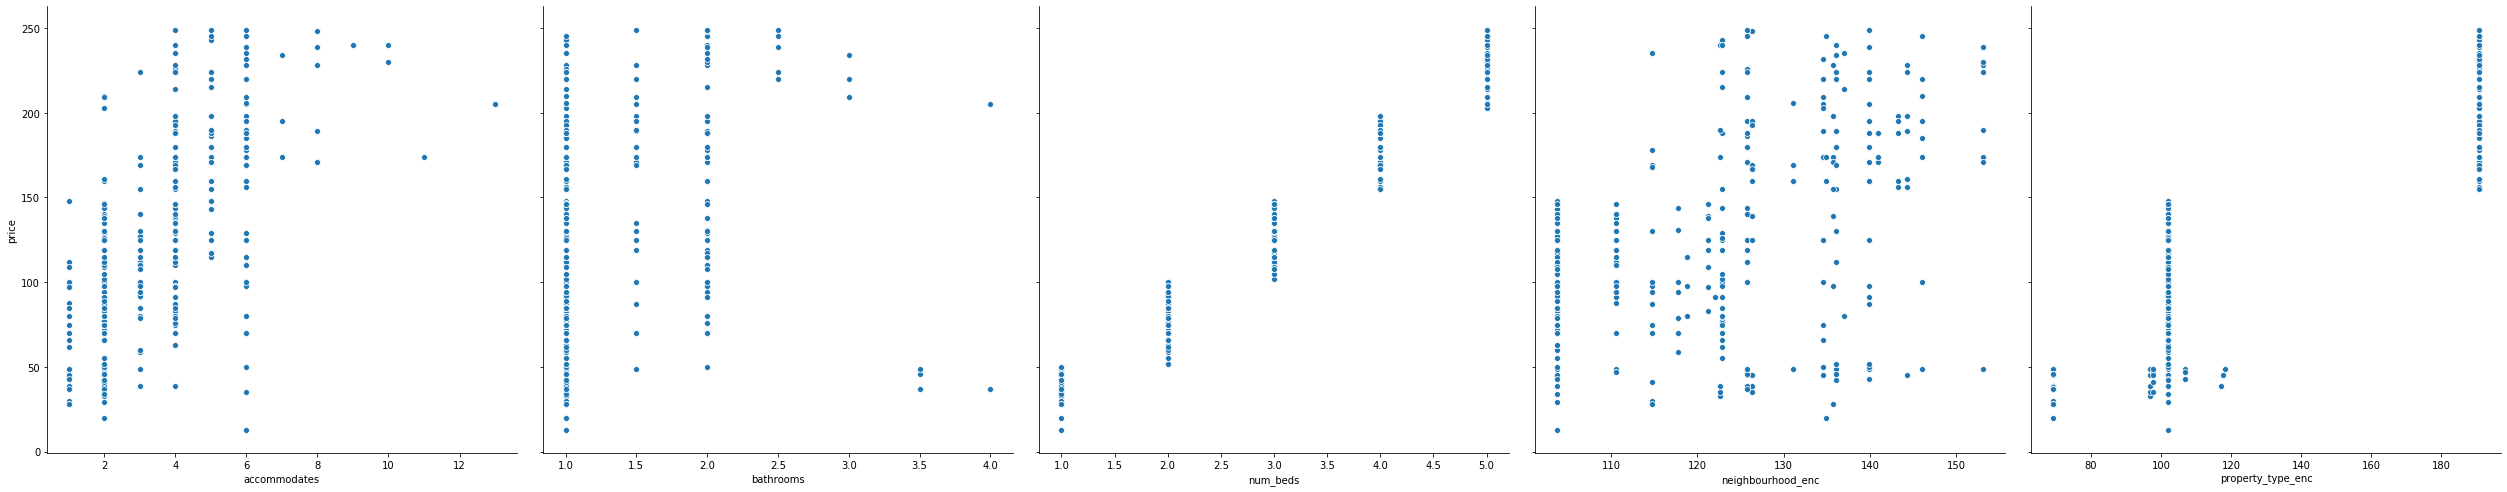

In [7]:
processed_df = pd.concat([X, Y], axis = 1, sort = True)

# visualise relationship between preditors and response
sns_pairplot = sns.pairplot(processed_df, 
             x_vars=features, 
             y_vars='price', height = 7)
sns_pairplot.savefig("pairplot.png")

Preliminary analysis on the relationship between each predictors and response shows that there are no correlation between the predictors and response except for num_beds. num_beds could be a good feature for the regression model

              accommodates  bathrooms  num_beds
accommodates      1.000000   0.388128  0.626619
bathrooms         0.388128   1.000000  0.214590
num_beds          0.626619   0.214590  1.000000


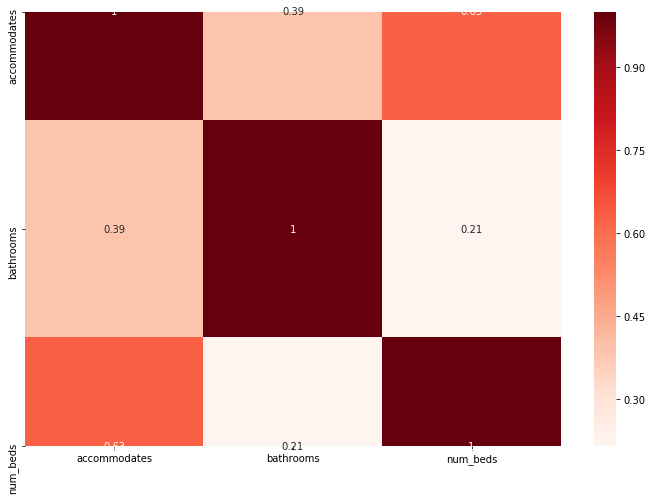

In [8]:
plt.figure(figsize=(12,8))
tmp_df = processed_df.loc[:,["accommodates", "bathrooms", "num_beds"]]
correlation = tmp_df.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.savefig("heatmap.png")
print (correlation)

In [9]:
# Part D

from sklearn.linear_model import LinearRegression 

regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

print("Intercept:", regression_model.intercept_[0])
coeeficients = list(zip(features, regression_model.coef_.flatten()))
print ()
print ("Coeeficients:")
for key, value in coeeficients:
    print (key, ":", value)

Intercept: -16.087156927139247

Coeeficients:
accommodates : 0.9437327017100727
bathrooms : 0.8425132584712445
num_beds : 43.58961324093963
neighbourhood_enc : 0.023533517409756066
property_type_enc : 0.06795076729431715


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = X_train.assign(const=1)
VIF_values = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print ("VIF values")
for i in range (len(VIF_values)):
    print(X_vif.columns[i] + " :", VIF_values[i])

VIF values
accommodates : 1.9819814181055386
bathrooms : 1.2411705560891328
num_beds : 4.482987090525004
neighbourhood_enc : 1.6226404074137883
property_type_enc : 6.080857006928336
const : 88.02514430439362


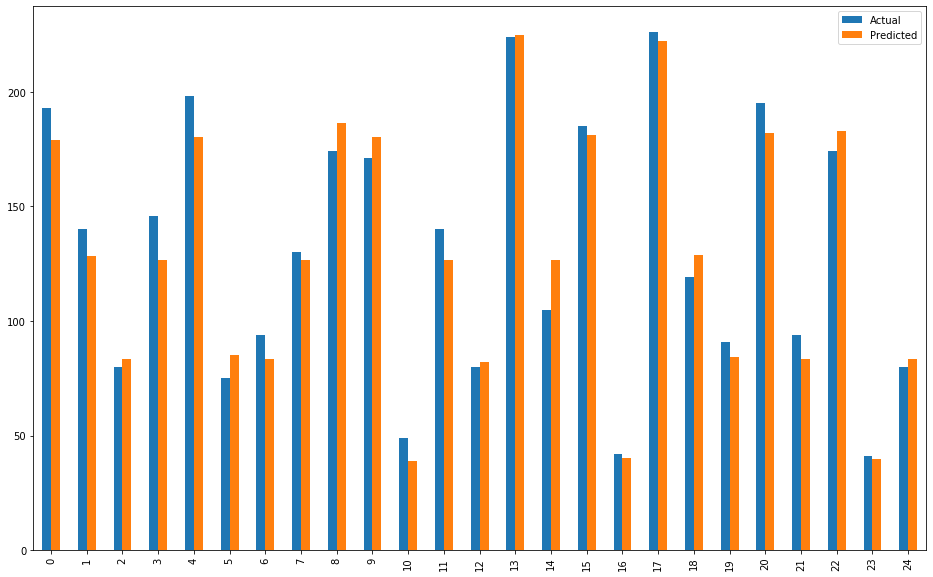

In [19]:
# Part E

result_df = pd.DataFrame({"Actual": Y_test.values.flatten(), "Predicted": regression_model.predict(X_test).flatten()}, index = range(len(Y_test)))
result_df.head(25).plot(kind='bar',figsize=(16,10))
plt.savefig("result.png")

Comparison of the actual and predicted values from testing dataset shows that the prediction values are close to the actual value

In [12]:
import numpy as np

print("Mean Absolute Error:", metrics.mean_absolute_error(result_df["Actual"], result_df["Predicted"]))
print("Mean Squared Error:", metrics.mean_squared_error(result_df["Actual"], result_df["Predicted"]))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(result_df["Actual"], result_df["Predicted"])))

Mean Absolute Error: 10.394079700310774
Mean Squared Error: 155.00993872164184
Root Mean Squared Error: 12.450298740256871


In [13]:
# make predictions of the price
def make_predictions (accommodates, bathrooms, num_beds, neighbourhood, property_type):
    neighbourhood_enc = mean_encode_neighbourhood[neighbourhood]
    property_type_enc = mean_encode_property_type[property_type]
    results = regression_model.predict([[accommodates, bathrooms, num_beds, neighbourhood_enc, property_type_enc]])
    return (results[0][0])

In [14]:
make_predictions(accommodates = 1.0, 
                 bathrooms = 1.0, 
                 num_beds = 1, 
                 neighbourhood = "Kitsilano", 
                 property_type = "Apartment")

36.94780007740522